<h1>Sentiment Analysis on Restaurant Customer Reviews</h1>

<i>N.Avgeros (March 2022)</i>

---

<h3>Introduction</h3>

This notebook aims at predicting the sentiment of customers' reviews. It is simply a sentiment analysis project, including various machine learning techniques to detect the customers' sentiment. In addition, it provides an introductory knowledge of NLP's "Data Preprocessing", "Bag Of Words" and "Machine Learning" steps.


<h3>Natural Language Processing (NLP)</h3>

Natural Language Processing (NLP) is a type of computational linguistics that uses machine learning algorithms to understand how us people communicate. This includes voice assistance, chat bots, sentiment analysis and many more.

With NLP, computers can understand human speech in text and written form without the need of someone to structure their conversation in any way.

<h3>What we'll be doing</h3>

In this kernel, the main steps for any NLP problem will be described, as well as their lines of code. This will help further analysis and will be a good starting point to build more complex models.

In the dataset of this exercise we have 1000 reviews from a restaurant, labeled as positive reviews (1) or negative ones (0).

We will be building different machine learning models that may predict, given the words used in the review, a label for each of the reviews in the test set.

<h3>Sentiment Analysis</h3>

Sentiment Analysis (also known as opinion mining or emotion AI) is a sub-field of NLP that tries to identify and extract opinions within a given text across blogs, reviews, social media, forums, news etc. Sentiment Analysis can help craft all this exponentially growing unstructured text into structured data using NLP and open source tools. This is what we are going to do here.




## Importing the libraries

In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from bs4 import BeautifulSoup
import re
import unicodedata
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display_html, display
import itertools
from itertools import chain, cycle
import collections
import time
import pickle

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

# NLTK
import nltk
nltk.download("stopwords")
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer

# Scikit Learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Changing the CSS styling

In [2]:
%%HTML
<style>.dataframe th{
background:#3f577c; 
font-family:monospace;
padding: 5px;
color:white;
border:1px solid white; 
text-align:center !important;}
</style>

## Importing the dataset

In [3]:
CSV_FILE = "Restaurant_Reviews.tsv"
data_df = pd.read_csv(CSV_FILE, sep="\t")
display(data_df.head(10))
print("\nDimensions: {}".format(data_df.shape))

,Review,Liked
0,Wow... Loved this place.,1
1,Crust is not good.,0
2,Not tasty and the texture was just nasty.,0
3,Stopped by during the late May bank holiday of...,1
4,The selection on the menu was great and so wer...,1
5,Now I am getting angry and I want my damn pho.,0
6,Honeslty it didn't taste THAT fresh.),0
7,The potatoes were like rubber and you could te...,0
8,The fries were great too.,1
9,A great touch.,1



Dimensions: (1000, 2)


## Cleaning the dataset

When working on a dataset, there are many chances for data to be incorrect or mislabeled. If data is wrong, outcomes and algorithms are unreliable, even though they may look correct. Data cleaning is the process of changing or eliminating garbage, incorrect, duplicate, corrupted, or incomplete data in a dataset. 
 
In our case, we will do the following:
<ul>
    <li>Handle missing data</li>
    <li>Check for incorrect data types</li>
</ul>

In [4]:
## Handle missing values

# Check NaN values
display(pd.DataFrame(data_df.isna().sum(), columns=['Missing data']))

# Empty spaces
print("\nEmpty spaces: {}".format(data_df["Review"].apply(lambda x: x.isspace()).sum()))

,Missing data
Review,0
Liked,0



Empty spaces: 0


In [5]:
## Check for incorrect data types
display(pd.DataFrame(data_df.dtypes, columns=['Type']))

,Type
Review,object
Liked,int64


In [6]:
pd.DataFrame(data_df['Liked'].value_counts())
## Alternative, but slower
# import pandasql 
# pandasql.sqldf("SELECT Liked, COUNT(Liked) AS Total FROM data_df GROUP BY Liked", locals())

,Liked
1,500
0,500


As we see, we have neither missing data nor empty spaces in reviews. In addition, our dataset contains only <mark>positive</mark> and <mark>negative</mark> reviews, meaning that <mark>neutral</mark> reviews are not included and the models we create will fail to detect neutral reviews. We keep in mind that when we test our best model with a single review.

## Sentiment Analysis using TextBlob & Sentiment Intensity Analyzer

### TextBlob

<strong>TextBlob</strong> is a python library for Natural Language Processing (NLP).TextBlob actively used Natural Language ToolKit (NLTK) to achieve its tasks. <strong>NLTK</strong> is a library which gives an easy access to a lot of lexical resources and allows users to work with categorization, classification and many other tasks. TextBlob is a simple library which supports complex analysis and operations on textual data.

In [7]:
sentiment_df = data_df.copy()
textblob_polarity = lambda x: 1 if TextBlob(x).sentiment.polarity > 0 else 0
sentiment_df['TextBlob'] = sentiment_df["Review"].apply(textblob_polarity)
display(sentiment_df.head(10))
textblob_predictions = sentiment_df['TextBlob'].values
liked_test = sentiment_df["Liked"].values
textblob_score = accuracy_score(liked_test, textblob_predictions) * 100
print("Accuracy score: {}%".format(textblob_score))

,Review,Liked,TextBlob
0,Wow... Loved this place.,1,1
1,Crust is not good.,0,0
2,Not tasty and the texture was just nasty.,0,0
3,Stopped by during the late May bank holiday of...,1,1
4,The selection on the menu was great and so wer...,1,1
5,Now I am getting angry and I want my damn pho.,0,0
6,Honeslty it didn't taste THAT fresh.),0,1
7,The potatoes were like rubber and you could te...,0,0
8,The fries were great too.,1,1
9,A great touch.,1,1


Accuracy score: 77.4%


The <mark>accuracy score is 77.4%</mark>. As we can see in Review column, we have short form of words with negative meaning such as <mark>hadn't</mark> or <mark>can't</mark> and for that reason the TextBlob class cannot extract the apropriate sentiment. For instance:

In [8]:
sample_text = "The movie wasn't good."
sample_text_polarity = TextBlob(sample_text).sentiment.polarity
print("Text: {} \nSentiment: {} \nPolarity: {}".format(sample_text,
                                                     "Positive" if sample_text_polarity > 0 else "Negative", 
                                                     sample_text_polarity))

Text: The movie wasn't good. 
Sentiment: Positive 
Polarity: 0.7


To deal with that, we can simply create a function called <strong>split_not</strong> in order to separate those words.

In [9]:
def split_not(text:str) -> str:
    """ Separates the short form of negative words. E.g. wasn't -> was not """
    text = text.split()
    for word_idx, word in enumerate(text):
        if "n't" in word:
            word = word.replace("n't", '')
            if word.lower() == 'wo':
                word = word.replace('o', 'ill')
            elif word.lower() == 'ca':
                word += 'n'
            text[word_idx] = word
            text.insert(word_idx+1, "not")
    return ' '.join(text)

In [10]:
sample_text = split_not("The movie wasn't good.")
sample_text_polarity = TextBlob(sample_text).sentiment.polarity
print("Text: {}\nSentiment: {}\nPolarity: {}".format(sample_text,
                                                     "Positive" if sample_text_polarity > 0 else "Negative", 
                                                     sample_text_polarity))

Text: The movie was not good.
Sentiment: Negative
Polarity: -0.35


As we can see from the above example, the function successfully recognised the negative review by replacing <mark>wasn't</mark> to <mark>was not</mark>. Now, we can recreate the <mark>Review</mark> column by applying the <mark>split_not</mark> function.

In [11]:
sentiment_df["Review"] = sentiment_df["Review"].apply(split_not)
sentiment_df['TextBlob'] = sentiment_df["Review"].apply(textblob_polarity)
display(sentiment_df.head(10))
textblob_predictions = sentiment_df['TextBlob'].values
textblob_score = round((accuracy_score(liked_test, textblob_predictions) * 100), 3)
print("Accuracy score: {}%".format(textblob_score))

,Review,Liked,TextBlob
0,Wow... Loved this place.,1,1
1,Crust is not good.,0,0
2,Not tasty and the texture was just nasty.,0,0
3,Stopped by during the late May bank holiday of...,1,1
4,The selection on the menu was great and so wer...,1,1
5,Now I am getting angry and I want my damn pho.,0,0
6,Honeslty it did not taste THAT fresh.),0,1
7,The potatoes were like rubber and you could te...,0,0
8,The fries were great too.,1,1
9,A great touch.,1,1


Accuracy score: 77.6%


With split_not function, we get a small accuracy boost, reaching <mark>77.6% accuracy.</mark>

### Sentiment Intensity Analyzer

Let's try a different class called <mark>Sentiment Intensity Analyzer</mark> from <mark>nltk.sentiment</mark> package to detect the polarity score and extract the sentiment.

In [12]:
sid_polarity = (lambda x: 1 if SentimentIntensityAnalyzer().polarity_scores(x)["compound"] > 0 else 0)
sentiment_df['SentimentIntensityAnalyzer'] = sentiment_df["Review"].apply(sid_polarity)
display(sentiment_df)
sid_predictions = sentiment_df['SentimentIntensityAnalyzer'].values
sid_score = accuracy_score(liked_test, sid_predictions) * 100
print("Accuracy score: {}%".format(sid_score))

,Review,Liked,TextBlob,SentimentIntensityAnalyzer
0,Wow... Loved this place.,1,1,1
1,Crust is not good.,0,0,0
2,Not tasty and the texture was just nasty.,0,0,0
3,Stopped by during the late May bank holiday of...,1,1,1
4,The selection on the menu was great and so wer...,1,1,1
...,...,...,...,...
995,I think food should have flavor and texture an...,0,0,0
996,Appetite instantly gone.,0,0,0
997,Overall I was not impressed and would not go b...,0,0,0
998,"The whole experience was underwhelming, and I ...",0,1,0


Accuracy score: 81.2%


It seems that the class <mark>Sentiment Intesity Analyzer performs better than Texblob</mark> class in our dataset, with accuracy score 81.2 percent.

## Sentiment Analysis using Scikit Learn

In the previous section, we have extracted the sentiment by using the TextBlob class from the textblob library. In this section, we will apply machine learing models in order to predict the sentiment from the customers' reviews. 

Before we start building machine learning models we need to clean our dataset. For that reason, we create a function called <mark>clean_text</mark> which will do the following:

<ol>
   <li>Converting review into lower case.</li>
   <li>Removing backslashes, underscores, dots, emails, urls, html tags, rt, accented, special & dups characters.</li>
   <li>Correcting abbreviations.</li>
   <li>Using PorterStemmer: produces morphological variants of a root/base word. E.g. “retrieval”, “retrieved” - >“retrieve”</li>
</ol>

In [13]:
def clean_text(text:str) -> str:
    
    """ 
    Text cleaning:
    1. Removing backslashes, underscores, dots, emails, urls, html tags, rt, digits, accented, special & dups characters.
    2. Converting review into lower case.
    3. Correcting abbreviations.
    3. Using PorterStemmer: produces morphological variants of a root/base word. E.g. “retrieval”, “retrieved” - >“retrieve”
    
    Parameters
        ----------
        review : str
            The customer's review
    """

    # Text cleaning
    text = str(text).lower().replace("\\", '').replace("_", '').replace(".", '')
    text = split_not(text) # correct abbreviations
    text = re.sub(r'([a-z0-9+._-]+@[a-z0-9+._-]+\.[a-z0-9+_-]+)',"", text) # remove emails
    text = re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , text) # remove urls
    text = BeautifulSoup(text, 'lxml').get_text().strip() # remove html tags
    text = re.sub(r'\brt\b', '', text).strip() # remove rt
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore') # remove accented chars
    text = re.sub(r'[^\w ]+', "", text) # remove special chars
    text = re.sub("(.)\\1{2,}", "\\1", text) # remove dups chars
    text = re.sub(" \d+", " ", text) # remove digits
    #text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text) # remove digits
    
    # Text tokenizer
    tokenizer = nltk.TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(text)
    
    # Creating a stopwords list
    all_stopwords = stopwords.words('english') # a list which contains all stopwords
    all_stopwords.remove("not") # remove 'not' from the stopwords list
    
    # Apply stemmer
    stemmer = nltk.PorterStemmer()
    review = [stemmer.stem(word) for word in tweet_tokens if word not in set(all_stopwords)]
    
    return ' '.join(review)

In [14]:
data_cleaned_df = data_df.copy()
data_cleaned_df["Review"] = data_cleaned_df["Review"].apply(clean_text)
display(data_cleaned_df)
print("\nEmpty spaces: {}".format(data_cleaned_df["Review"].apply(lambda x: x.isspace()).sum()))

,Review,Liked
0,wow love place,1
1,crust not good,0
2,not tasti textur nasti,0
3,stop late may bank holiday rick steve recommen...,1
4,select menu great price,1
...,...,...
995,think food flavor textur lack,0
996,appetit instantli gone,0
997,overal not impress would not go back,0
998,whole experi underwhelm think well go ninja su...,0



Empty spaces: 0


In [15]:
# Create a word list 
words_in_text = [row.split() for row in data_cleaned_df["Review"].tolist()]
all_words = list(itertools.chain(*words_in_text))

# Create counter
counts = collections.Counter(all_words)

# Term Frequency 
top_15_df = pd.DataFrame(counts.most_common(15), columns=["Word", "Term Frequency"])
top_15_df

,Word,Term Frequency
0,not,212
1,food,125
2,place,112
3,good,95
4,servic,84
5,great,70
6,go,61
7,back,61
8,time,55
9,like,51


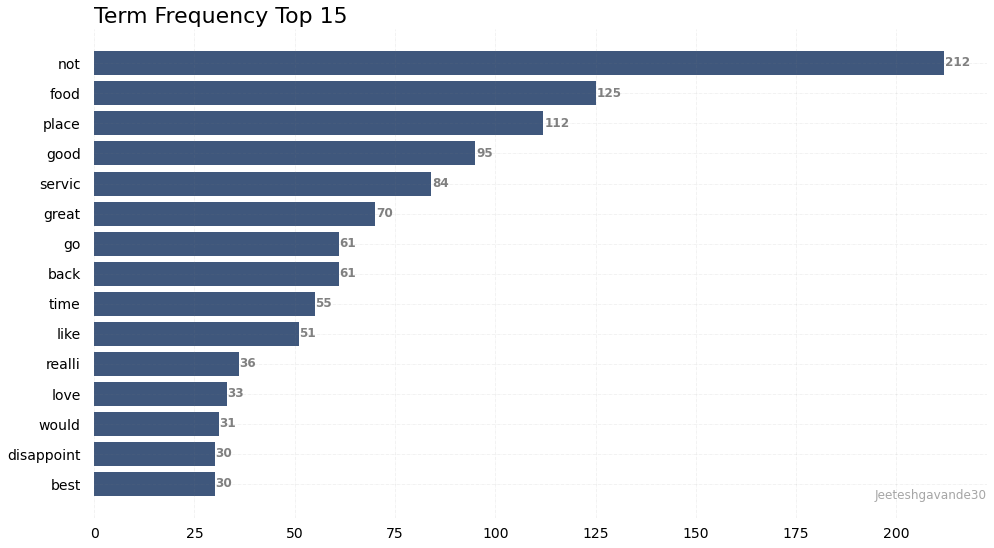

In [16]:
# Figure Size
fig, ax = plt.subplots(figsize=(16, 9))
  
# Horizontal Bar Plot
ax.barh(top_15_df['Word'], top_15_df['Term Frequency'], color='#3f577c')

# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=14)
ax.tick_params(axis='both', which='minor', labelsize=14)

# Remove x, y Ticks
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
  
# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=5)
ax.yaxis.set_tick_params(pad=10)
  
# Add x, y gridlines
ax.grid(b=True, color='grey', linestyle='-.', linewidth=0.5, alpha=0.2)
  
# Show top values
ax.invert_yaxis()
  
# Add annotation to bars
for i in ax.patches:
    plt.text(i.get_width() + 0.2,
             i.get_y() + 0.5,
             str(round((i.get_width()), 2)),
             fontsize = 12,
             fontweight = 'bold',
             color = 'grey')

# Add Plot Title
ax.set_title('Term Frequency Top 15 ', loc='left', size=22)
  
# Add Text watermark
fig.text(0.9, 0.15, 'Jeeteshgavande30', fontsize=12, color='grey', ha ='right', va='bottom', alpha=0.7)
  
# Show Plot
plt.show()

## CountVectorizer

Now let's create a matrix in which each unique word is represented by a column of the matrix, and each text sample from the document is a row in the matrix by using the class CountVectorizer. 

<strong>CountVectorizer</strong> is a great tool provided by the scikit-learn library in Python. It is used to transform a given text into a vector on the basis of the frequency (count) of each word that occurs in the entire text. This is helpful when we have multiple such texts, and we wish to convert each word in each text into vectors (for using in further text analysis).

Furthermore, we split our dataset into features and label where features are the descriptive attributes, and the label is what we are attempting to predict. In our case, features is the Review column and label the Liked column.

In [17]:
cv = CountVectorizer()
X = cv.fit_transform(data_cleaned_df["Review"].values)
y = data_cleaned_df.Liked.values

In [18]:
# Document Term Matrix
dtm_df = pd.DataFrame(X.toarray(), columns=cv.get_feature_names(), index=[f"Review {i}" for i in data_cleaned_df.index])
dtm_df.head(10)

,absolut,absolutley,accid,accommod,accomod,accordingli,account,ach,acknowledg,across,...,yelper,yet,youd,youll,your,yucki,yukon,yum,yummi,zero
Review 0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Review 1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Review 2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Review 3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Review 4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Review 5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Review 6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Review 7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Review 8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Review 9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now, we will double check the Document Term Matrix which we have created.<br> In order to check it, we can simply find in which reviews appear the word <mark>wow</mark> both in our original dataset and in the Document Term Matrix.

In [19]:
 # Document Term Matrix dataset
dtm_df[dtm_df["wow"]==1][['wow', 'love', 'place']]

,wow,love,place
Review 0,1,1,1
Review 277,1,0,0
Review 438,1,0,0


In [20]:
# Original dataset
data_cleaned_df[data_cleaned_df['Review'].str.contains('wow')]

,Review,Liked
0,wow love place,1
277,goat taco not skimp meat wow flavor,1
438,wow spici delici,1


Both queries returned three reviews containing the word <mark>wow</mark>, meaning that our Document Term Matrix has been successfuly created.

## Training and Test sets

Before we apply any machine learning model in our dataset, we have to split it into training and test set in order to evaluate the performance of the models.

To achieve that, we will use the <mark>train_test_split</mark> function from scikit learn library and split the dataset with the size of 0.80 (80 percent) for the training set and 0.20 (20 percent) for test set. 

In [21]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, list(data_cleaned_df.index), test_size=0.2, random_state=0)
print("Training features: {}\nTesting features: {}\nTraining labels: {}\nTesting labels: {}".format(X_train.shape,
                                                                                                    X_test.shape,
                                                                                                    y_train.shape,
                                                                                                    y_test.shape))

Training features: (800, 1589)
Testing features: (200, 1589)
Training labels: (800,)
Testing labels: (200,)


## Machine Learning techniques using the default parameters

The very first thing we do is to run various machine learning models, in order to quickly see the performance of our models. In that case, we create a for loop to avoid writing multiple lines of code and store our results in a dictionary for later use. In the dictionary we will keep the predictions, the accuracy score and the confusion matrix for each model we create.

In [22]:
ml_models = [LogisticRegression, SGDClassifier, RandomForestClassifier, SVC, MLPClassifier]
for model in ml_models:
    print(model.__name__)

LogisticRegression
SGDClassifier
RandomForestClassifier
SVC
MLPClassifier


In [23]:
default_performance_dict = {"Predictions":{},
                          "Accuracy Score":{},
                          "Confusion Matrix":{}}

for ml_model in ml_models:
    model = ml_model(random_state=0)
    model.fit(X_train, y_train)
    
    model_pred = model.predict(X_test)

    default_performance_dict["Predictions"][ml_model.__name__] = model_pred
    default_performance_dict["Accuracy Score"][ml_model.__name__] = accuracy_score(y_test, model_pred) * 100
    default_performance_dict["Confusion Matrix"][ml_model.__name__] = confusion_matrix(y_test,model_pred)

In [24]:
default_performance_df = pd.DataFrame(default_performance_dict).sort_values(by="Accuracy Score", ascending=False)
default_performance_df[["Accuracy Score", "Confusion Matrix"]]

,Accuracy Score,Confusion Matrix
SVC,83.5,"[[84, 13], [20, 83]]"
RandomForestClassifier,82.5,"[[83, 14], [21, 82]]"
MLPClassifier,82.5,"[[78, 19], [16, 87]]"
LogisticRegression,82.0,"[[80, 17], [19, 84]]"
SGDClassifier,80.5,"[[78, 19], [20, 83]]"


## Visualizing the Confusion matrix 

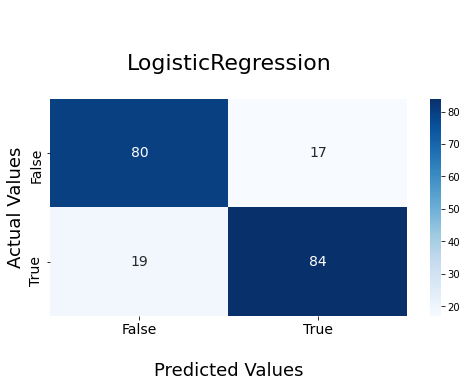

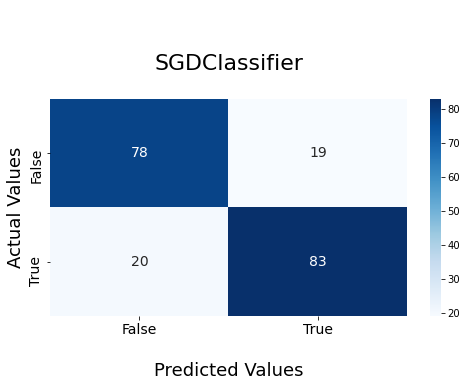

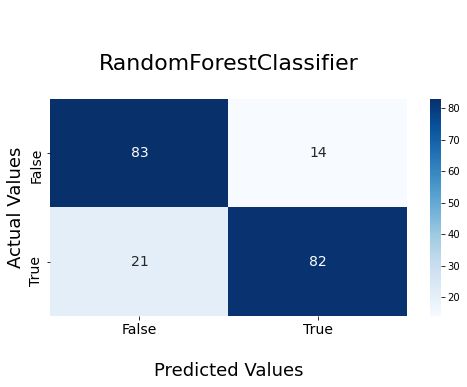

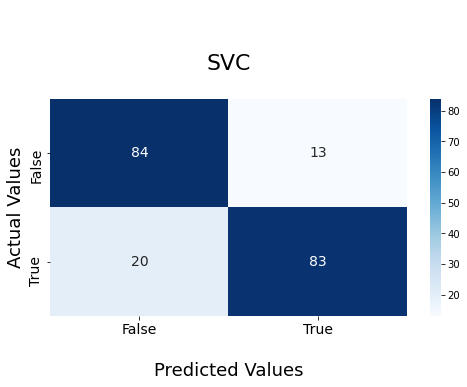

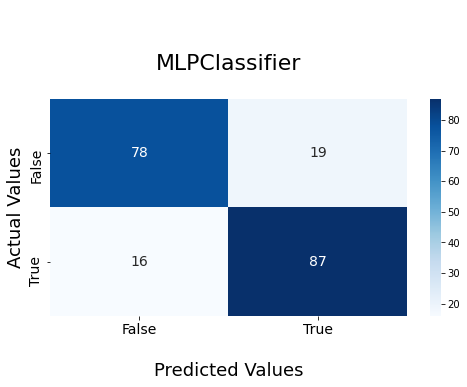

In [25]:
for model, cm in default_performance_dict["Confusion Matrix"].items(): 
    fig, ax = plt.subplots(figsize=(8, 4))
    
    ax = sns.heatmap(cm, annot=True, cmap='Blues', annot_kws={'size': 14})

    ax.set_title("\n\n{}\n".format(model), size=22);
    ax.set_xlabel('\nPredicted Values', size=18)
    ax.set_ylabel('Actual Values', size=18);

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['False','True'], size=14)
    ax.yaxis.set_ticklabels(['False','True'], size=14)

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## Machine Learning techniques using GridSearch

In the previous section, we have trained different models on the dataset in order to find out the one with the best performance. However, there is room for improvement as we cannot say for sure that this particular model is best for the problem at hand. Hence, our aim is to improve the model in any way possible. One important factor in the performances of these models are their hyperparameters, once we set appropriate values for these hyperparameters, the performance of a model can improve significantly. In this article, we will find out how we can find optimal values for the hyperparameters of a model by using <strong>GridSearchCV</strong>.

<strong>GridSearchCV</strong> tries all the combinations of the values passed in the dictionary and evaluates the model for each combination using the Cross-Validation method. Hence after using this function we get accuracy/loss for every combination of hyperparameters and we can choose the one with the best performance.

For that reason, we create a dictionary which contains all the hyperparameters we want to apply in our models.

In [26]:
# Timer 
def timer(start, end):
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    return "{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds)

In [27]:
grid_performance_dict = dict()

grid_performance_dict["LogisticRegression"] = {"param_grid": {"solver": ['newton-cg', 'lbfgs', 'liblinear'],
                                                         "penalty": ['l1', 'l2', 'none', 'elasticnet'],
                                                         "C": list(np.arange(1,10)),
                                                        }}


grid_performance_dict["SVC"] = {"param_grid": {"C":list(np.arange(1, 10)),
                                          "kernel":["linear", "rbf", "sigmoid"],
                                         }}
                  
grid_performance_dict["RandomForestClassifier"] = {"param_grid": {"n_estimators": list(range(100, 200, 10)),
                                                                  "max_depth": [*list(range(20, 30)), None],
                                                                  'criterion' :['entropy', 'gini'],
                                                                 }}
        
grid_performance_dict["SGDClassifier"] = {"param_grid": {"loss" : ["hinge", "log"],
                                                    "alpha" : [0.0001, 0.001, 0.01, 0.1],
                                                    "penalty" : ["l2", "l1", "none", 'elasticnet'],
                                                   }}

grid_performance_dict["MLPClassifier"] = {"param_grid": {'hidden_layer_sizes': [(100,),
                                                                                (192,),
                                                                                (240,)],
                                                         'alpha': [0.0001, 0.1, 1],
                                                        }}

In [28]:
start = time.time()

for ml_model in ml_models: 
    
    model_start = time.time()
    
    grid_search = GridSearchCV(estimator = ml_model(random_state=0),
                               param_grid = grid_performance_dict[ml_model.__name__]["param_grid"],
                               scoring = 'accuracy',
                               #n_jobs = -1,
                               cv = 5)
    
    grid_search.fit(X_train, y_train)
    
    grid_pred = grid_search.predict(X_test)

    grid_performance_dict[ml_model.__name__]["Predictions"] = grid_pred
    grid_performance_dict[ml_model.__name__]["Accuracy Score"] = accuracy_score(y_test, grid_pred) * 100
    grid_performance_dict[ml_model.__name__]["Confusion Matrix"] = confusion_matrix(y_test, grid_pred)
    grid_performance_dict[ml_model.__name__]["Best Parameters"] = grid_search.best_params_
    
    print("{}: {}% -> {}\nTimer: {}\n".format(ml_model.__name__,
                                     grid_performance_dict[ml_model.__name__]["Accuracy Score"],
                                     grid_performance_dict[ml_model.__name__]["Best Parameters"],
                                     timer(model_start, time.time())))
    
print("\nTOTAL RUN TIME: {}".format(timer(start, time.time())))

LogisticRegression: 82.0% -> {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Timer: 00:00:06.88

SGDClassifier: 83.0% -> {'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}
Timer: 00:00:00.40

RandomForestClassifier: 84.0% -> {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 150}
Timer: 00:05:40.75

SVC: 81.5% -> {'C': 4, 'kernel': 'rbf'}
Timer: 00:00:03.77

MLPClassifier: 82.0% -> {'alpha': 1, 'hidden_layer_sizes': (192,)}
Timer: 00:05:24.68


TOTAL RUN TIME: 00:11:16.48


In [29]:
# GridSearchCV Performance
grid_performance_df = pd.DataFrame(grid_performance_dict.values(),
                                   index = grid_performance_dict.keys())[["Accuracy Score",
                                                                        "Best Parameters",
                                                                        "Confusion Matrix"]].sort_values(by = "Accuracy Score",
                                                                                                         ascending = False)
grid_performance_df

,Accuracy Score,Best Parameters,Confusion Matrix
RandomForestClassifier,84.0,"{'criterion': 'entropy', 'max_depth': None, 'n...","[[85, 12], [20, 83]]"
SGDClassifier,83.0,"{'alpha': 0.001, 'loss': 'log', 'penalty': 'l2'}","[[81, 16], [18, 85]]"
LogisticRegression,82.0,"{'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}","[[80, 17], [19, 84]]"
MLPClassifier,82.0,"{'alpha': 1, 'hidden_layer_sizes': (192,)}","[[80, 17], [19, 84]]"
SVC,81.5,"{'C': 4, 'kernel': 'rbf'}","[[82, 15], [22, 81]]"


## Comparing the performances

For comparison, we create a function called <mark>compare_dataframes</mark> to display side by side the dataframes we have created, but before that we recalculate the accuracy score from Textblob and Sentiment Intensity Analyzer, since we have tested them in the whole dataset in the first section. To achieve that can query the rows with the indices we kept in the splitting section and then we can compare the dataframes.

In [30]:
textblob_sid_df = pd.DataFrame(columns=["Review", "TextBlob", "SentimentIntensityAnalyzer"])
for idx in indices_test:
    row = sentiment_df.loc[idx, ["Review", "TextBlob", "SentimentIntensityAnalyzer"]].to_dict()
    textblob_sid_df = textblob_sid_df.append(row, ignore_index=True)
textblob_sid_df.index = indices_test
textblob_sid_df["Liked"] = y_test
textblob_sid_df["TextBlob"] = textblob_sid_df["TextBlob"].astype(int)
textblob_sid_df["SentimentIntensityAnalyzer"] = textblob_sid_df["SentimentIntensityAnalyzer"].astype(int)
textblob_sid_df

,Review,TextBlob,SentimentIntensityAnalyzer,Liked
993,the presentation of the food was awful.,0,0,0
859,Worst food/service I've had in a while.,0,0,0
298,Never again will I be dining at this place!,0,0,0
553,I guess maybe we went on an off night but it w...,0,0,0
672,As a sushi lover avoid this place by all means.,0,1,0
...,...,...,...,...
679,Service was slow and not attentive.,0,0,0
722,"The food was great as always, compliments to t...",1,1,1
215,Waitress was good though!,1,1,1
653,"Not much flavor to them, and very poorly const...",0,0,0


In [31]:
grid_predictions_df = pd.DataFrame({key:grid_performance_dict[key]["Predictions"]
                                    for key in list(grid_performance_dict.keys())},
                                   index = indices_test)
grid_predictions_df

,LogisticRegression,SVC,RandomForestClassifier,SGDClassifier,MLPClassifier
993,0,0,0,0,0
859,0,0,0,0,0
298,0,0,0,0,0
553,0,0,0,0,0
672,0,0,0,0,0
...,...,...,...,...,...
679,0,0,0,0,0
722,1,1,1,1,1
215,1,1,1,1,1
653,0,0,0,0,0


In [32]:
# All predictions 
predictions_df = textblob_sid_df.join(grid_predictions_df)
predictions_df = predictions_df.reset_index().reindex(columns=['index', 'Review', 'Liked', 'TextBlob', 
                                                               'SentimentIntensityAnalyzer','LogisticRegression',
                                                               'SVC', 'RandomForestClassifier', 'SGDClassifier', 
                                                               'MLPClassifier'])
predictions_df.rename(columns = {'index': 'ReviewId'}, inplace=True)
predictions_df

,ReviewId,Review,Liked,TextBlob,SentimentIntensityAnalyzer,LogisticRegression,SVC,RandomForestClassifier,SGDClassifier,MLPClassifier
0,993,the presentation of the food was awful.,0,0,0,0,0,0,0,0
1,859,Worst food/service I've had in a while.,0,0,0,0,0,0,0,0
2,298,Never again will I be dining at this place!,0,0,0,0,0,0,0,0
3,553,I guess maybe we went on an off night but it w...,0,0,0,0,0,0,0,0
4,672,As a sushi lover avoid this place by all means.,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
195,679,Service was slow and not attentive.,0,0,0,0,0,0,0,0
196,722,"The food was great as always, compliments to t...",1,1,1,1,1,1,1,1
197,215,Waitress was good though!,1,1,1,1,1,1,1,1
198,653,"Not much flavor to them, and very poorly const...",0,0,0,0,0,0,0,0


In [33]:
def compare_dataframes(*args, titles=cycle([''])):
    
    """ 
    Display dataframes side by side 
    
    Inputs
    ------
        *args: pandas dataframes
        titles: titles of each dataframe
    
    Returns
    -------
        pandas dataframes displayed side by side by using the display_html() function from IPython.display package
    
    """
    
    html_str=''
    
    for df,title in zip(args, chain(titles,cycle(['</br>']))):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
        
    display_html(html_str,raw=True)

In [34]:
y_textblob = predictions_df["TextBlob"].values
y_sid = predictions_df["SentimentIntensityAnalyzer"].values
textblob_score = accuracy_score(y_test, y_textblob) * 100
sid_score = accuracy_score(y_test, y_sid) * 100
textblob_sid_performance_df = pd.DataFrame({"Accuracy Score":[textblob_score, sid_score]},
                                           index=["TextBlob", "SentimentIntensityAnalyzer"]).sort_values(by="Accuracy Score",
                                                                                                         ascending=False)

compare_dataframes(default_performance_df[["Accuracy Score"]], 
                   grid_performance_df[["Accuracy Score"]], 
                   textblob_sid_performance_df,
                   titles=['Default','Grid Search', 'TextBlob & SID'])

,Accuracy Score
SVC,83.5
RandomForestClassifier,82.5
MLPClassifier,82.5
LogisticRegression,82.0
SGDClassifier,80.5
,Accuracy Score
RandomForestClassifier,84.0
SGDClassifier,83.0
LogisticRegression,82.0
MLPClassifier,82.0


As we see, the <mark>Random Forest Classifier</mark> has the best performance whit <mark>accuracy score 84 percent</mark>. 

Now, we can build our best machine learning model by passing the best parameters which have been occured by GridSearchCV class.

## Best Model

In [35]:
best_model_name = grid_performance_df.index[0] # RandomForestClassifier

best_model_dict = {best_model_name:{"Predictions":[], "Accuracy Score":[], "Confusion Matrix":[]}}


criterion, max_depth, n_estimators = list(grid_performance_dict[best_model_name]["Best Parameters"].values())

best_model = RandomForestClassifier(criterion=criterion,
                                    max_depth=max_depth,
                                    n_estimators=n_estimators)
best_model.fit(X_train, y_train)

best_model_predictions = best_model.predict(X_test)
   
best_model_dict[best_model_name]["Predictions"] = best_model_predictions
best_model_dict[best_model_name]["Accuracy Score"] = accuracy_score(y_test, best_model_predictions) * 100
best_model_dict[best_model_name]["Confusion Matrix"] = confusion_matrix(y_test, best_model_predictions)

best_model_df = pd.DataFrame(best_model_dict.values(), index=best_model_dict.keys())[["Accuracy Score", "Confusion Matrix"]]
best_model_df

,Accuracy Score,Confusion Matrix
RandomForestClassifier,81.5,"[[77, 20], [17, 86]]"


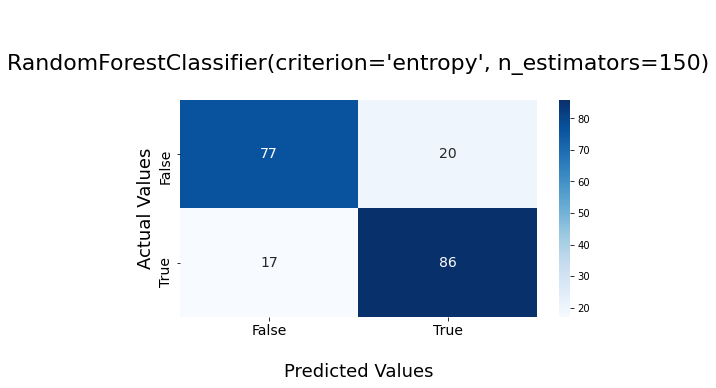

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))

ax = sns.heatmap(best_model_dict[best_model_name]["Confusion Matrix"], annot=True, cmap='Blues', annot_kws={'size': 14})

ax.set_title("\n\n{}\n".format(best_model), size=22);
ax.set_xlabel('\nPredicted Values', size=18)
ax.set_ylabel('Actual Values', size=18);

# Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'], size=14)
ax.yaxis.set_ticklabels(['False','True'], size=14)

# Display the visualization of the Confusion Matrix.
plt.show()

## Saving the results

In [37]:
predictions_df.to_csv("final_results.csv", index=False)

## Saving the best model & CounterVectorizer

In [38]:
pickle.dump(best_model, open('RandomForestClassifier', 'wb'))
pickle.dump(cv, open('CountVectorizer', 'wb'))

## Single review prediction

Let's create a function which predicts the sentiment from a single review by using our best model.

In [39]:
def predict_review(review, model='RandomForestClassifier', cv='CountVectorizer', sentiment=True, display_transform=True):
    
    """ 
    Predicts the sentiment from a single text by using the passed machine learning model. 
    
    Inputs
    ------
        review: string, The text for prediction
        model: string, The saved machine learning model
        cv: string, The saved count vectorizer 
        sentiment: boolean, if it's true returns the sentinent as a string , otherwise as an integer
        display_transform: boolean, prints the initial text and the output from the clean_text function 
    
    Returns
    -------
        string if the sentiment is True, otherwise integer
    
    """
        
    # Text preprocessing
    text = review[:]
    text = clean_text(text)
    
    # Loading best model & CountVectorizer
    loaded_model = pickle.load(open(model, 'rb'))
    loaded_cv = pickle.load(open(cv, 'rb'))
    
    # Predictions
    prediction = loaded_model.predict(loaded_cv.transform([text]))[0]
    
    # Outputs
    if display:
        print("Before: {}\nAfter: {}".format(review, text))
        
    if sentiment:
        return "Positive" if prediction > 0 else "Negative"
    else:
        return prediction

In [40]:
# Positive Review
predict_review('The service was not good.')

Before: The service was not good.
After: servic not good


'Negative'

In [41]:
# Negative Review
predict_review('The dishes were delicious!')

Before: The dishes were delicious!
After: dish delici


'Positive'

In [42]:
# Neutral Review -> FAIL
predict_review("The place is red")

Before: The place is red
After: place red


'Positive'

## Conclusion

Sentiment analysis or opinion mining is a field of study that analyzes people’s sentiments, attitudes, or emotions towards certain entities. In our case, we have trained the models only for positive and negative reviews, meaning that our best model fail to detect neutral reviews. However, for negative and positive reviews we have 84% accuracy to predict the sentiment of a customer's review.
